In [1]:
import numpy as np
from numpy.fft import rfft, irfft, rfftfreq
from scipy.integrate import complex_ode as ode
import matplotlib.pyplot as plt

# Kuramoto-Sivashinsky.

$ u_t + \alpha uu_x + \beta u_{xx} +\gamma u_{xxxx} = 0$ with periodic boundary condition and an initial condition $u_0(x)$.

In [2]:
def kuramoto_sivashinsky(u0, domain=[-1,1], N=64, alpha=5., beta=.5, gamma=.005):
    x_L, x_R = domain
    domain_x = np.linspace(x_L, x_R, N, endpoint=False)
    u0hat = rfft(u0(domain_x))
    
    freq = rfftfreq(N, (x_R - x_L)/N)
    i_2pi_k = 2j * np.pi * freq

    def eqn(t, uhat):
        uux = -alpha*i_2pi_k * rfft(0.5*irfft(uhat, N)**2)
        uxx = -beta*i_2pi_k**2 * uhat
        uxxxx = -gamma*i_2pi_k**4 * uhat
        out = uux + uxx + uxxxx
        return out
    
    return eqn, u0hat

## Regular Regime.

Spatial domain $x\in [-1,1]$,
coefficients $\alpha, \beta, \gamma = 5, 0.5, 0.005$,
initial condition $u_0(x) = -\sin(\pi x)$,
and we want the solution up to time $t =1$.

In [3]:
def solve(u0, domain=[-1,1], N=65,
          alpha=5., beta=.5, gamma=.005,
          dt=0.0005, T=1.
          ):
    spectral, u0hat = kuramoto_sivashinsky(u0,domain,N,alpha,beta,gamma)
    solver = ode(spectral)
    solver.set_integrator("vode", method="bdf")
    solver.set_initial_value(u0hat, 0.)
    t, uhat = [], []

    while solver.successful() and (time:=solver.t) < T:
        solver.integrate(time+dt)
        t.append(time)
        uhat.append(solver.y)
        
    return t, np.stack(uhat)

20001


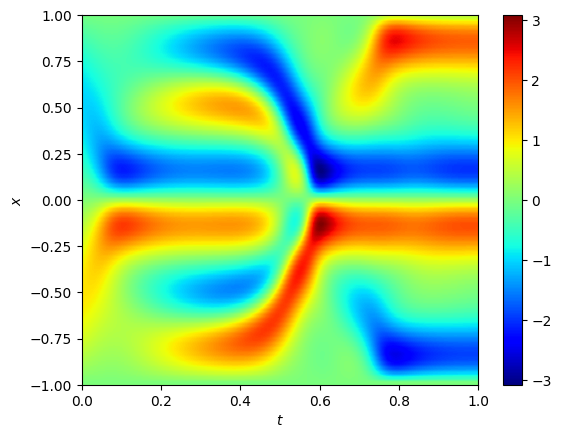

In [4]:
def u0(x):
    return -np.sin(np.pi*x)

mode = 77
t, uhat = solve(u0, domain=[-1,1], N=mode, 
                alpha=5., beta=.5, gamma=.005,
                dt=5e-5, T=1.)
print(len(t))

sol = irfft(uhat, mode, axis=-1)
plt.imshow(sol.T, cmap='jet', origin='lower', aspect='auto', extent=[t[0],t[-1],-1,1])
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.colorbar()
plt.show()

## Chaotic Regime.

Parameters are given by $\alpha, \beta, \gamma = \frac{100}{16}, \frac{100}{16^2}, \frac{100}{16^4}$, a spatial domain is $x\in [0,2\pi]$, and an initial condition $\cos(x)(1+\sin(x))$.

We want the solution at $T=0.9$.

1801


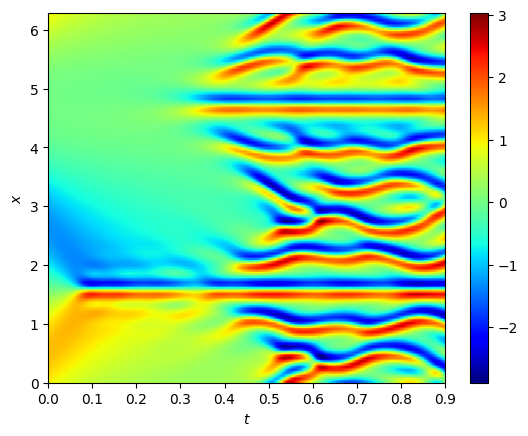

In [6]:
def u0(x):
    return np.cos(x)*(1+np.sin(x))

mode = 127
t, uhat = solve(u0, domain=[0,2*np.pi], N=mode, 
                alpha=100/16, beta=100/(16**2), gamma=100/(16**4), 
                dt=5e-4, T=0.9)
print(len(t))

sol = irfft(uhat, mode, axis=-1)
plt.imshow(sol.T, cmap='jet', origin='lower', aspect='auto', extent=[t[0],t[-1],0,2*np.pi])
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.colorbar()
plt.show()